In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from toolkit import LightCurve
import h5py
import numpy as np

archive = h5py.File('archive.hdf5', 'r')

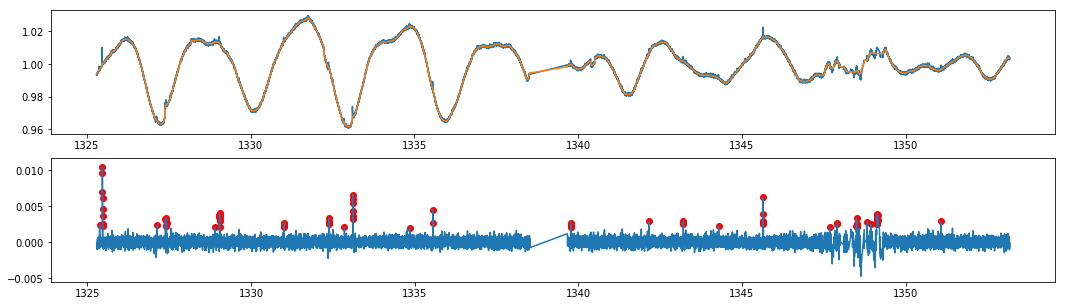

In [11]:
from scipy.ndimage import median_filter

entry = archive['01/00410214986']
times, fluxes = entry[:]
fluxes /= np.median(fluxes)


filtered = median_filter(fluxes, (55,))

peaks = np.argwhere(fluxes - filtered > 0.002)

fig, ax = plt.subplots(2, 1, figsize=(18, 5))
ax[0].plot(times, fluxes)
ax[0].plot(times, filtered)

ax[1].plot(times, fluxes - filtered)

ax[1].scatter(times[peaks], (fluxes - filtered)[peaks], color='r')

In [12]:
t0 = entry.attrs['Epoc']
period = entry.attrs['Period']
duration = entry.attrs['Duration']

In [17]:
period

8.1375

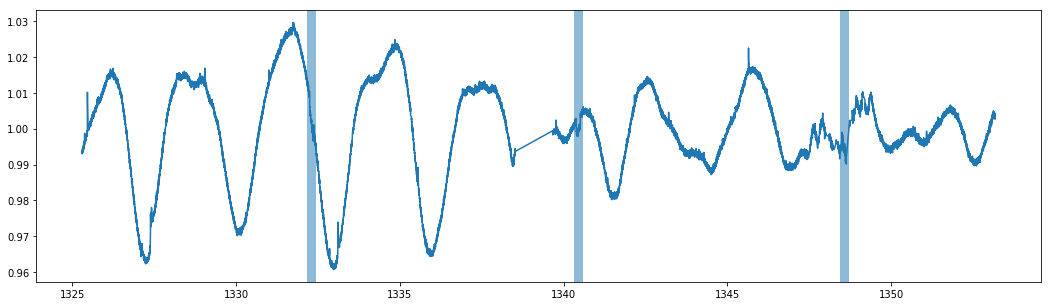

In [21]:
fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(times, fluxes)
ax.axvspan(t0 - duration/24, t0 + duration/24, alpha=0.5)
ax.axvspan(t0 - duration/24 + period, t0 + duration/24 + period, alpha=0.5)
ax.axvspan(t0 - duration/24 + 2*period, t0 + duration/24 + 2*period, alpha=0.5)

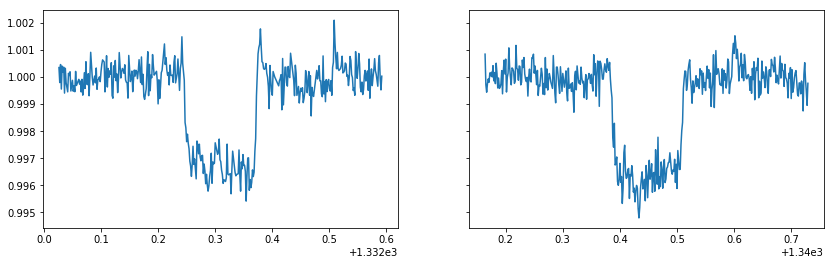

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

first = ((t0 - 2*duration/24 < times) & (t0 + 2*duration/24 > times))
first_oot = first & np.logical_not(np.abs(times - t0) < duration/24/2)

second = ((t0 - 2*duration/24 + period < times) & (t0 + 2*duration/24 + period > times))
second_oot = second & np.logical_not(np.abs(times - (t0 + period)) < duration/24/2)

first_poly = np.polyval(np.polyfit(times[first_oot], fluxes[first_oot], 2), times[first])
second_poly = np.polyval(np.polyfit(times[second_oot], fluxes[second_oot], 2), times[second])

ax[0].plot(times[first], fluxes[first] / first_poly)
ax[1].plot(times[second], fluxes[second] / second_poly)

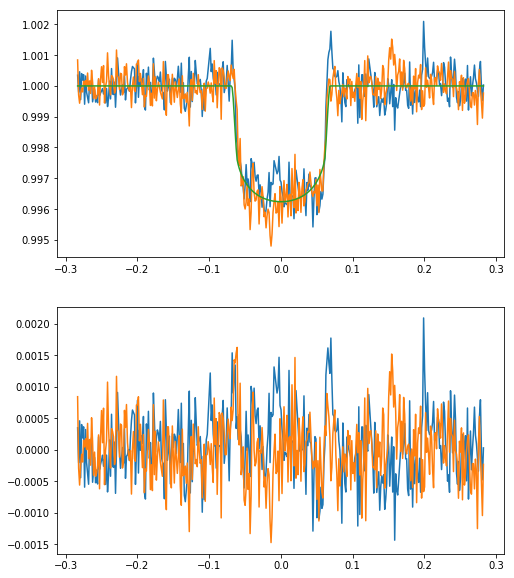

In [52]:
from robin import TransitModel, TransitParams

params = TransitParams()
params.per = period
params.p0 = 0.056
params.p1 = 0.056
params.a = 20
params.limb_dark = 'quadratic'
params.u = [0.4, 0.2]
params.t0 = t0
params.ecc = 0
params.w = 0
params.inc = 90

m = TransitModel(params, times[first])
lc_first = m.light_curve(params)

m = TransitModel(params, times[second])
lc_second = m.light_curve(params)

fig, ax = plt.subplots(2, 1, figsize=(8, 10))
ax[0].plot(times[first] - t0, fluxes[first] / first_poly)
ax[0].plot(times[second] - (t0 + period), fluxes[second] / second_poly)
ax[0].plot(times[first] - t0, lc_first)

ax[1].plot(times[first] - t0, fluxes[first] / first_poly - lc_first)
ax[1].plot(times[second] - (t0 + period), fluxes[second] / second_poly - lc_second)